In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from typing import List
import seaborn as sns
import matplotlib as mpl
from itertools import cycle
from src.political_party_analysis.loader import DataLoader
from src.political_party_analysis.dim_reducer import DimensionalityReducer
from src.political_party_analysis.visualization import scatter_plot, plot_density_estimation_results, plot_finnish_parties
from src.political_party_analysis.estimator import DensityEstimator

In [2]:
df_original= pd.read_stata('data/CHES2019V3.dta')
df_original.set_index(["party_id", "party", "country"], inplace=True)
df= df_original.copy()

In [3]:
# Identify duplicate rows
# duplicates = df[df.duplicated()]
df = df.drop_duplicates()
# print('Shape of df before and after removing duplicates: df_orginal.shape, df.shape')
print(f"Shape of DataFrame before and after removing duplicates: {df_original.shape}, {df.shape}")


Shape of DataFrame before and after removing duplicates: (277, 52), (277, 52)


In [4]:
# df.fillna(df.mean(), inplace=True)

def impute_numerical_columns_with_knn(df, n_neighbors=5):
    """
    Automatically finds all numerical columns in a DataFrame and imputes missing values
    using KNNImputer.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame.
        n_neighbors (int): Number of neighbors to consider for KNNImputer.
        
    Returns:
        pd.DataFrame: A DataFrame with missing values in numerical columns imputed.
    """
    # Identify numerical columns
    numerical_cols = df.select_dtypes(include=['number']).columns
    
    # Copy the DataFrame to avoid modifying the original
    df_imputed = df.copy()
    
    # Apply KNNImputer to numerical columns only
    if not numerical_cols.empty:
        imputer = KNNImputer(n_neighbors=n_neighbors)
        df_imputed[numerical_cols] = imputer.fit_transform(df_imputed[numerical_cols])
    
    return df_imputed

df= impute_numerical_columns_with_knn(df)

In [5]:
def scale_feat(df: pd.DataFrame) -> pd.DataFrame:
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df)
    scaled_df = pd.DataFrame(scaled_data, columns=df.columns)
    return scaled_df

df= scale_feat(df)
# df['lrgen']= 10*df['lrgen']


In [6]:
# Reduce the data to 2D
dimensionality_red= DimensionalityReducer(data= df, model= None, n_components= 2)
reduced_data = dimensionality_red.reduce_to_2d()

    # Print the result
# print("Reduced Data:", reduced_data)

In [7]:
density_estimator= DensityEstimator(reduced_data)
kde_model = density_estimator.model_distribution(bandwidth= 0.1)
# Step 2: Randomly sample 10 parties
sampled_parties = density_estimator.sample_parties(kde_model, n_samples=10)
# print("Sampled Parties (Reduced Space):\n", sampled_parties)

# original_space= density_estimator.map_to_original_space(df)

In [9]:
orientation_df = df.loc[:, df.columns.str.startswith('l')]
def comp_orientation(df, col_names):
    orientation= df[col_names[0]] + df[col_names[1]] - df[col_names[2]]
    return orientation

political_orient= comp_orientation(df,
                              orientation_df.columns)

def encode_continuous_to_classes(series, bins, labels=None):
    """
    Encodes a continuous variable into discrete classes.
    
    Parameters:
        series (pd.Series): The continuous variable to encode.
        bins (list): A list of bin edges. For example, [1, 4, 7, 10] creates three bins: 1-4, 4-7, and 7-10.
        labels (list, optional): A list of labels for the bins. If None, the bins are labeled with integers.
        
    Returns:
        pd.Series: A new series with the encoded classes.
    """
    if labels is None:
        labels = range(len(bins) - 1)
    return pd.cut(series, bins=bins, labels=labels, include_lowest=True)

# Define the bins and optional labels
# bins = [1, 4, 7, 10]  # 1-4, 4-7, 7-10
bins = [0.1, 0.4, 0.7, 10] 
labels = [1, 2, 3]
orientation= encode_continuous_to_classes(political_orient, bins, labels= labels)

# orientation= encode_continuous_to_classes(df['lrgen'], bins, labels= labels)
# print(orientation)
df['Orientation']= np.array(orientation.values)
# df= df.drop(['lrgen'], axis=1)
df= df.drop(orientation_df.columns, axis=1)

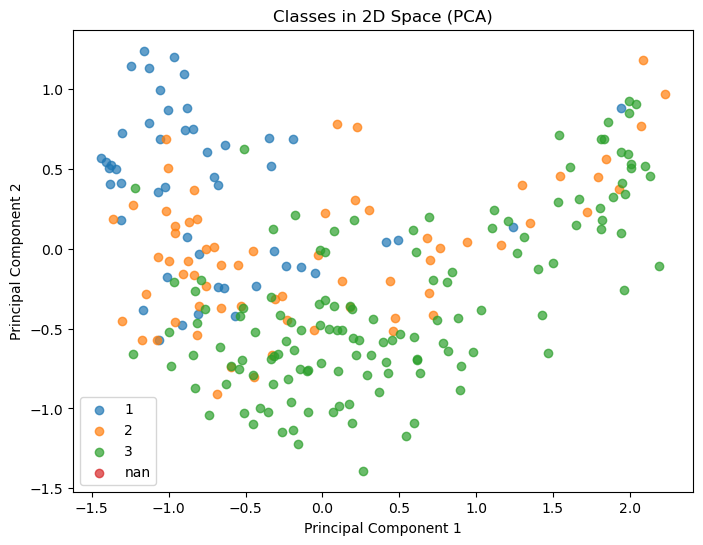

In [11]:
# Convert to DataFrame for plotting
reduced_df = pd.DataFrame(reduced_data, columns=['PC1', 'PC2'])
reduced_df['class'] = orientation.values

# Plot the classes in 2D space
plt.figure(figsize=(8, 6))
for cls in reduced_df['class'].unique():
    subset = reduced_df[reduced_df['class'] == cls]
    plt.scatter(subset['PC1'], subset['PC2'], label=cls, alpha=0.7)

plt.title('Classes in 2D Space (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


In [12]:
def plot_density_estimation_results_(
    X: pd.DataFrame,
    Y_: np.ndarray,
    means: np.ndarray,
    covariances: np.ndarray,
    title: str):
    """Use this function to plot the estimated distribution"""


    color_iter = cycle(["navy", "c", "cornflowerblue", "gold", "darkorange", "g"])
    plt.figure(figsize=(8, 6))
    splot = plt.subplot()

    unique_classes = np.unique(Y_)
    for i, (label, color) in enumerate(zip(unique_classes, color_iter)):
        cluster_points = X[Y_ == label]
        mean = means[i]
        covar = covariances[i]

        # Scatter plot
        splot.scatter(cluster_points['PC1'], cluster_points['PC2'], color=color, label=f"Class {label}", alpha=0.7)

        # Ellipse plot for covariance
        v, w = np.linalg.eigh(covar)
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan(u[1] / u[0])
        angle = 180.0 * angle / np.pi
        ell = mpl.patches.Ellipse(mean, v[0], v[1], angle=180.0 + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.show()


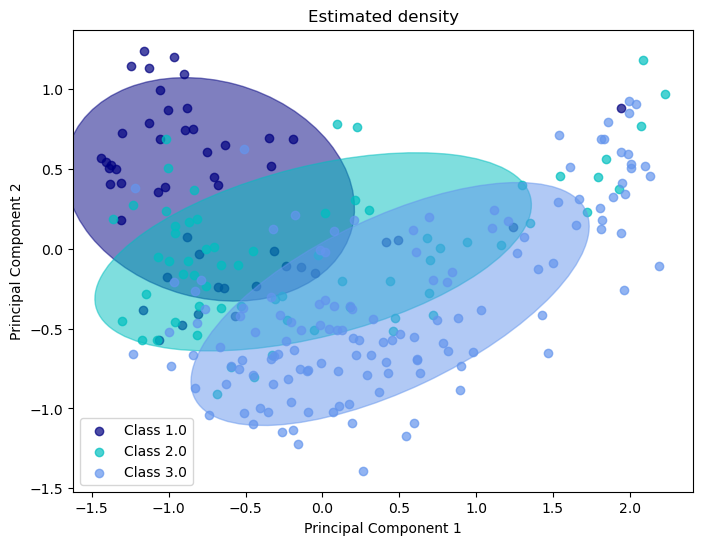

In [13]:
X= pd.DataFrame(reduced_data, columns=['PC1', 'PC2'])
Y_= np.array(orientation.values)
valid_indices = ~pd.isna(Y_)
X = X[valid_indices]
Y_ = Y_[valid_indices]
title= 'Estimated density'
# Compute means and covariances for each class
means = []
covariances = []

for cls in np.unique(Y_):
    subset = X[Y_ == cls]
    means.append(subset.mean().values)
    covariances.append(subset.cov().values)

means = np.array(means)  # Convert to numpy array
covariances = np.array(covariances)  # Convert to numpy array


plot_density_estimation_results_(
    X= X,
    Y_= Y_,
    means= means,
    covariances= covariances,
    title= title)

(10, 52)


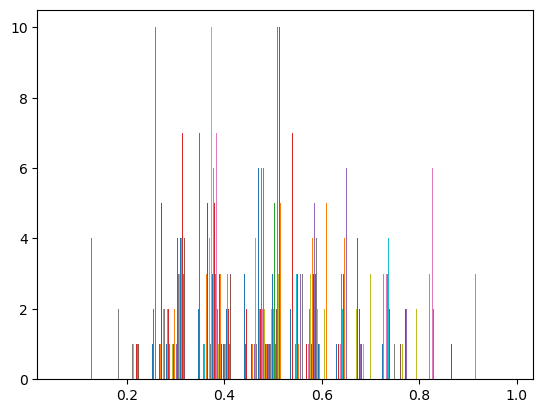

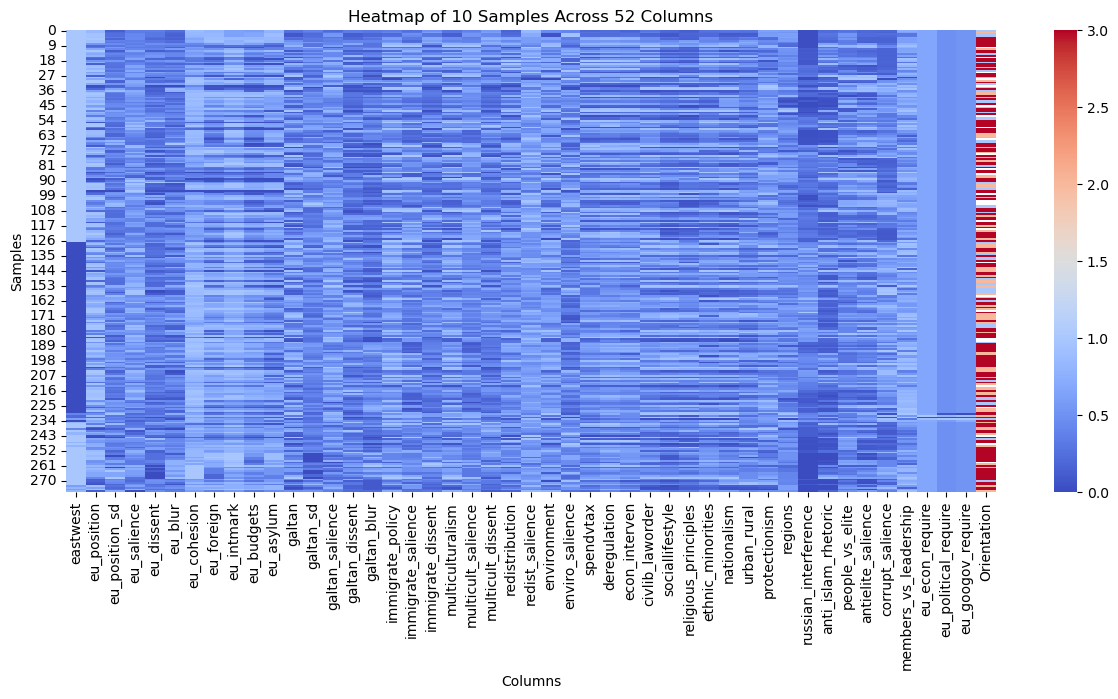

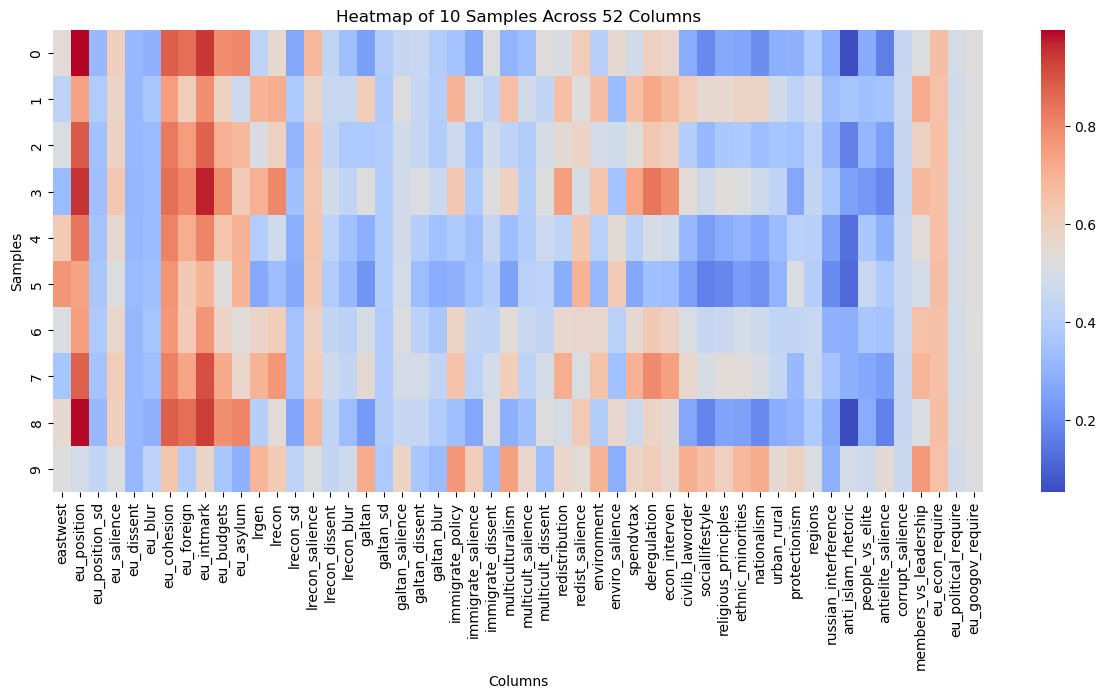

In [14]:
recovered_parties= dimensionality_red.map_to_original_space(sampled_parties)
print(recovered_parties.shape)

plt.hist(pd.DataFrame(recovered_parties, columns= df_original.columns))
plt.show()


def heatmap_viz(df: pd.DataFrame):
    df_num= df.select_dtypes(include=['number'])
    plt.figure(figsize=(15, 6))
    sns.heatmap(df_num, cmap="coolwarm", annot=False)
    plt.title("Heatmap of 10 Samples Across 52 Columns")
    plt.xlabel("Columns")
    plt.ylabel("Samples")
    plt.show()

heatmap_viz(df)
heatmap_viz(pd.DataFrame(recovered_parties, columns= df_original.columns))

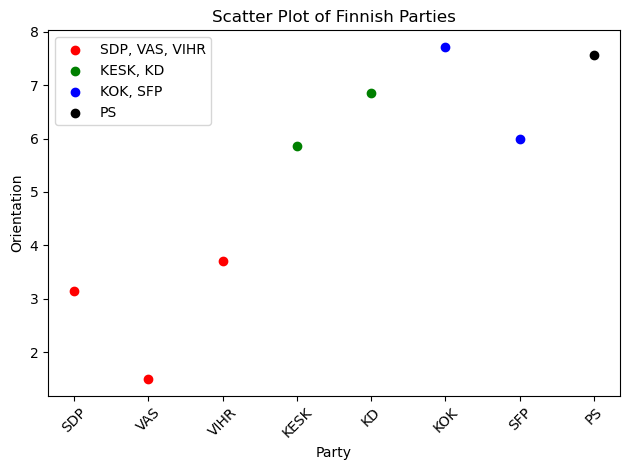

In [15]:
df_orientation= pd.DataFrame(data= df_original['lrgen'])
df_orientation.index= df_original.index
plot_finnish_parties(df_orientation)